# First Notebook for Machine Learning Intro Lecture

## KNN

### How does it work?

Recap the functioning of k-NN:
* For each test data point calculate the distance to all train data points using any distance measures
* Most common measures 
    * Metric features: 
        * Euclidean distance: $D_2(a, b) = \sqrt{(a_1 - b_1)^2 + ... + (a_p - b_p)^2}$
        * Manhattan distance: $D_1(a, b) = |a_1 - b_1| + ... + |a_p - b_p| $
        * Mahalanobis Distance: $D_{Mahalanobis}(a, b) = \sqrt{(a_i - b_i)^T \Sigma^{-1}(a_i - b_i)}$
    * Categorical features:
        * Simple Matching Coefficient:
        * Jaccard Coefficient: 
        * Rao's Coefficient: 
* Select the k nearest neighbors for each test data point and use the most frequent neighborhood class as prediction


Use the dummy data set iris with only numeric features and split in test and train data:

In [2]:
data(iris)
str(iris)
set.seed(1327)
trainSize = 3/4
trainIndices = sample(x = seq(1, nrow(iris), by = 1), size = ceiling(trainSize * nrow(iris)), replace = FALSE)
irisTrain = iris[ trainIndices, ]
irisTest = iris[ -trainIndices, ]

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


### Introductory Example

Imagine five data points:

In [3]:
ill.df = iris[c(1, 2, 3, 55, 110), -4]
levels(ill.df[, "Species"]) = c(levels(ill.df[, "Species"]), "???")
ill.df[3, "Species"] = "???"
print(ill.df)

    Sepal.Length Sepal.Width Petal.Length    Species
1            5.1         3.5          1.4     setosa
2            4.9         3.0          1.4     setosa
3            4.7         3.2          1.3        ???
55           6.5         2.8          4.6 versicolor
110          7.2         3.6          6.1  virginica


Which class would you select as prediction for the third observation?

In [4]:
# [Bug in jupyter 5](https://github.com/JuliaLang/IJulia.jl/issues/528) start notebook with this 
# flag from terminal: jupyter notebook --NotebookApp.iopub_data_rate_limit=2147483647 <data path>

suppressMessages(library(plotly))
p = plot_ly(ill.df, x = ~ Sepal.Length, y = ~ Sepal.Width, z = ~ Petal.Length, color = ~ Species, 
            colors = c('#6edaa7', '#6e70da', "#e0ba5c", "#3b2e38")) %>%
            add_markers() %>%
            layout(scene = list(xaxis = list(title = 'Sepal.Length'),
                     yaxis = list(title = 'Sepal.Width'),
                     zaxis = list(title = 'Petal.Length')))
embed_notebook(p)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Implementation

The function takes target Y, traindata, the testdata on which we want to perform knn classification as well as the k parameter. We also include the option to normalize the features (Why is that important?).

In [2]:
get.knn = function(Y, train.data, test.data, k, normalize = FALSE){
    
    n = nrow(test.data)
    pred = rep(as.character(NA), n)
    
    train.labels = train.data[, Y]
    test.labels = test.data[, Y]
    
    # delete Y column from training and test sets
    train.data[, Y] = NULL
    test.data[, Y] = NULL
    
    # normalize the feature vectors if desired
    if (normalize == TRUE) {
        train.data = apply(train.data, MARGIN = 2, FUN = function(x) (x - max(x)) / (max(x) - min(x)) )
        test.data = apply(test.data, MARGIN = 2, FUN = function(x) (x - max(x)) / (max(x) - min(x)) )
    }

    # we could eliminate the following loop with another apply, better this way for explanation
    for (i in 1:n) {
        # compute squared euclidean distances to all instances in training set
        nn = order(apply(train.data, 1, function(x) sum((x - test.data[i, ])^2)))[1:k]
        # compute frequencies of classes
        class.frequency = table(train.labels[nn])
        most.frequent.classes = names(class.frequency)[class.frequency == max(class.frequency)]
        # tie breaking
        pred[i] = sample(most.frequent.classes, 1) 
    }
                         
    # calculate test error
    pred.err = round(sum(ifelse(pred != test.labels, 1, 0)) / n, 4)                   
    
    # return list of values
    return(list(prediction = pred, levels=levels(train.labels), mmce = pred.err))
}


Test the algorithm

In [3]:
# test on 10 flowers
result = get.knn(Y = "Species", train.data = irisTrain, test.data = irisTest, k = 1, normalize = FALSE)
print(paste0("mean misclassififation error on test data: ", result$mmce))
head(cbind(irisTest, result$prediction))

[1] "mean misclassififation error on test data: 0.0811"


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,result$prediction
1,5.1,3.5,1.4,0.2,setosa,setosa
12,4.8,3.4,1.6,0.2,setosa,setosa
17,5.4,3.9,1.3,0.4,setosa,setosa
20,5.1,3.8,1.5,0.3,setosa,setosa
22,5.1,3.7,1.5,0.4,setosa,setosa
29,5.2,3.4,1.4,0.2,setosa,setosa


Check the confusion matrix for the predictions

In [4]:
print(table(result$prediction, irisTest$Species))

            
             setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         14         0
  virginica       0          3         8


Run and test it for different k's:


In [34]:
k.values = c(1, 2, 3, 5, 7, 9, 11, 15, 50)
storage = data.frame(matrix(NA, ncol = 2, nrow = length(k.values)))
colnames(storage) = c("mmce", "k")
for (i in 1:length(k.values)) {
    storage[i, "mmce"] = get.knn(Y = "Species", train.data = irisTrain, 
                                 test.data = irisTest, k = k.values[i], 
                                normalize = FALSE)$mmce
    storage[i, "k"] = k.values[i]
}
print(storage)


    mmce  k
1 0.0811  1
2 0.0811  2
3 0.0541  3
4 0.0541  5
5 0.0270  7
6 0.0541  9
7 0.0270 11
8 0.0270 15
9 0.0811 50


### Normalization


We included the option to normalize features according to the rule

$$
x_{normalized} = \frac{x - max(x)}{max(x) - min(x)}
$$

This makes sense, if features are on totally different scales (e.g. centimeter vs. meter). In such a case we would compare apples with oranges and the distances would be weighted unequally. Does it improve performannce with our data?


In [35]:
k.values = c(1, 2, 3, 5, 7, 9, 11, 15, 50)
storage = data.frame(matrix(NA, ncol = 2, nrow = length(k.values)))
colnames(storage) = c("mmce", "k")
for (i in 1:length(k.values)) {
    storage[i, "mmce"] = get.knn(Y = "Species", train.data = irisTrain, 
                                 test.data = irisTest, k = k.values[i], 
                                normalize = TRUE)$mmce
    storage[i, "k"] = k.values[i]
}
print(storage)

    mmce  k
1 0.1351  1
2 0.1351  2
3 0.1351  3
4 0.1081  5
5 0.1351  7
6 0.0811  9
7 0.0811 11
8 0.0811 15
9 0.1351 50


### mlr implementation

The mlr package offers a unified interface to many different machine learning algorithms making complicated implementations as above unnecessary. Check the [tutorial](https://mlr-org.github.io/mlr-tutorial/devel/html/learner/index.html#modifying-a-learner) and the [list of integrated learners](https://mlr-org.github.io/mlr-tutorial/release/html/integrated_learners/). It uses a simple syntax, as used below:


In [9]:
library(mlr)
# define task
irisTask = makeClassifTask(data = irisTrain, target = "Species")
# define learner and check possible models on mlr homepage
# getParamSet(irisLearner)
irisLearner = makeLearner("classif.kknn", k = 5)
# train the model
irisModel = train(learner = irisLearner, task = irisTask)
# predict on test data
irisPred = predict(irisModel, newdata = irisTest[, -5])
# check confusion matrix
print(table(irisPred$data$response, irisTest$Species))
# calculate mmce
(mmce = round(length(which(irisPred$data$response != irisTest$Species)) / length(irisPred$data$response), 5))

            
             setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         14         0
  virginica       0          3         8


[1] 0.08108

## Linear model and loss minimization 


### Problem
We learned that we can estimate the $\hat \beta$ coefficients in two ways:
   1. Solving the normal equation $X^TX \beta = X^TY$ for $\beta$ s.t. $\hat \beta = (X^TX)^{-1}X^Ty$. This is how it is implemented (with some fancy matrix decompositions) in R in the ```lm()``` function. 
   2. By minimizing the emiprical risk $$R_{emp}(f) = \frac{1}{n}\sum_{i=1}^n L(y_i, f(x_i | \beta))$$ of our estimator over $\beta$ with quadratic loss such that: $$ R_{emp}(f) = \frac{1}{n}\sum_{i=1}^n (y_i - x_i^T \hat\beta)^2$$. 
   
   This can be written in matrix notation as: $$R_{emp}(f) = \frac{1}{n}(X \beta - Y)^T (X\beta - Y) = \frac{1}{n}[\beta^T X^T X \beta - 2 \beta^TX^TY + Y^TY]$$
   
Now we compare both methods and check if they yield the same results for the iris data. We use the quadratic loss and yield this minimization problem w.r.t. $\beta$:

### Solution 
We solve this equation using an iterative technique termed __Gradient Descent__ which follows this algorithm:
1. Initialize $\beta_0$ randomly
3. Calculate the Gradient of our loss function with respect to the current $\beta$: 
$$
\frac{\partial R_{emp}(f)}{\partial \beta} = \nabla_{\beta} \frac{1}{n}[\beta^T X^T X \beta - 2 \beta^TX^TY + Y^TY] = \frac{1}{n}X^T[X\beta - Y]
$$
2. in each step, we update the estimate for $\beta$ using this formula:
$$
\beta_{t+1} = \beta_{t} - \lambda \frac{\partial R_{emp}(f)}{\partial \beta}
$$
3. We stop when the updates of $\beta$ are beyond a certain threshold or the maximum iterations are reached. 


### Implementation

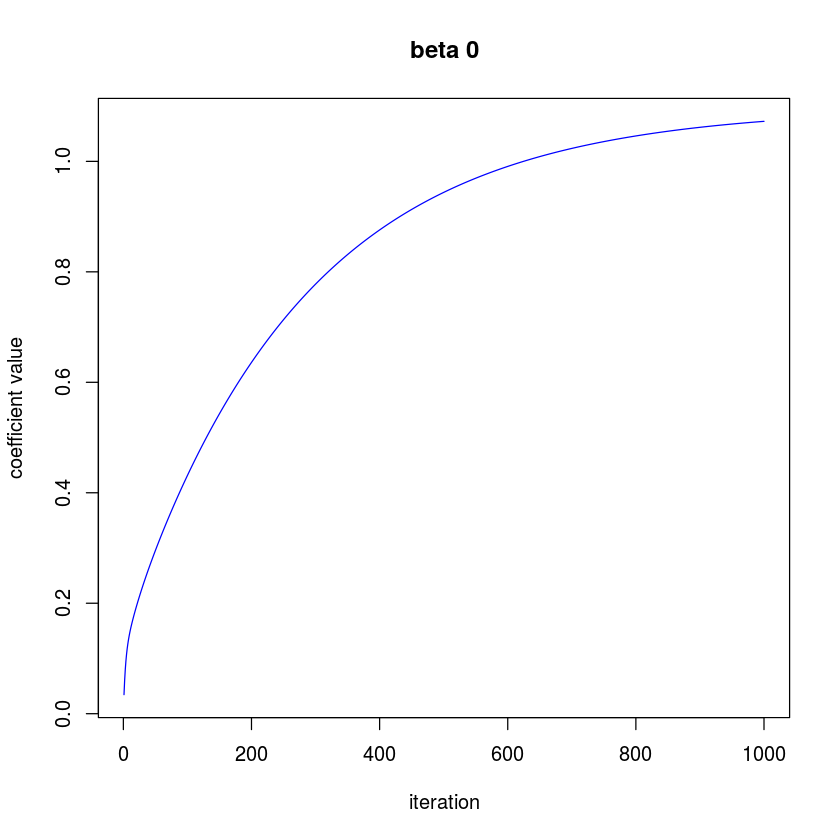

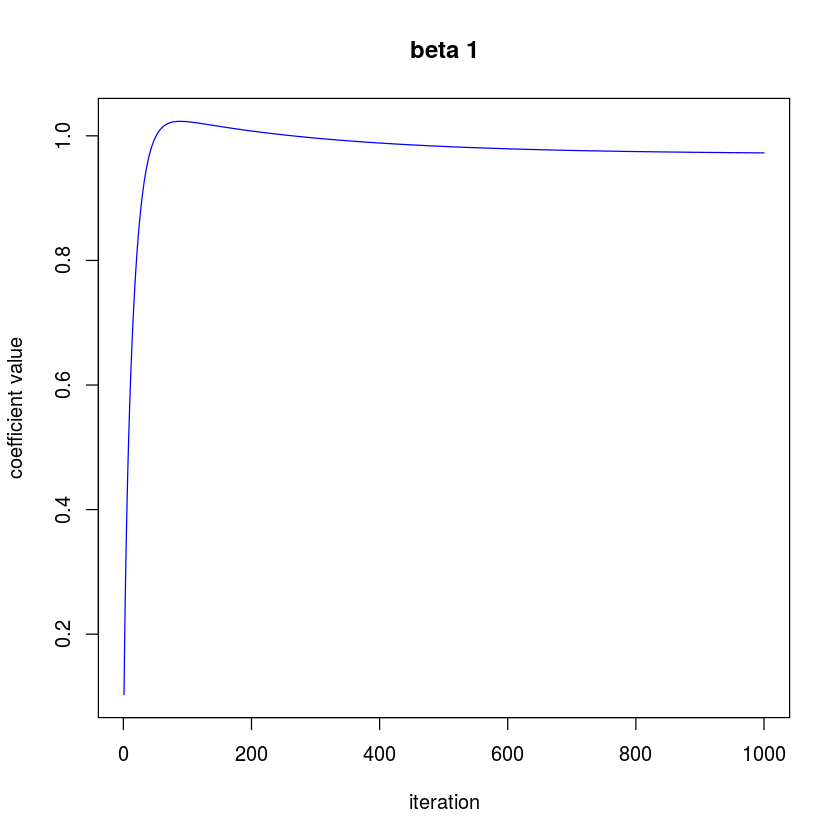

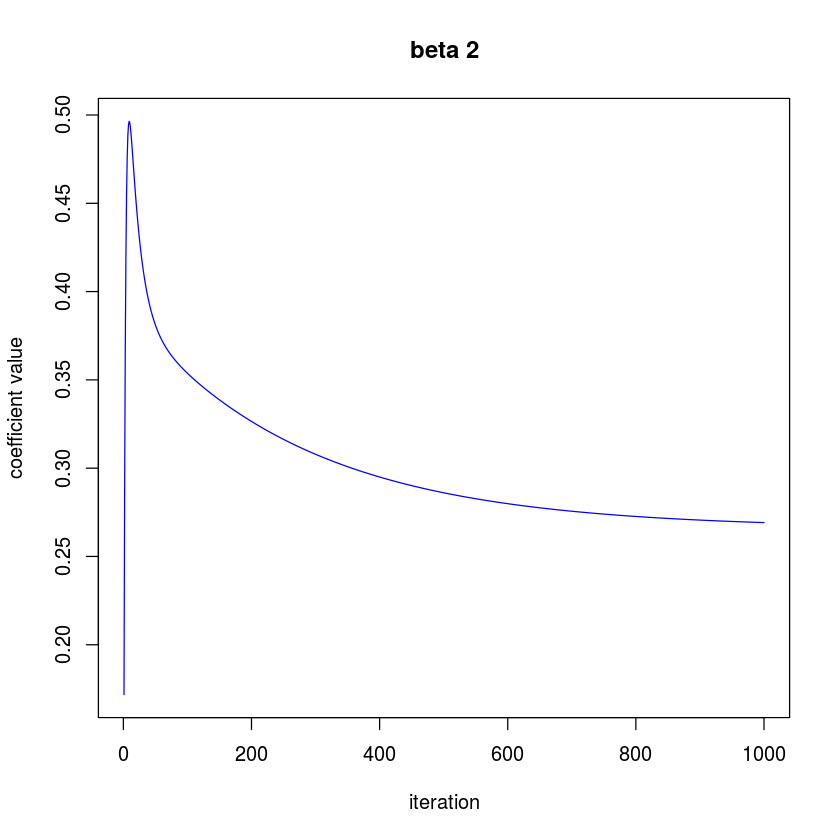

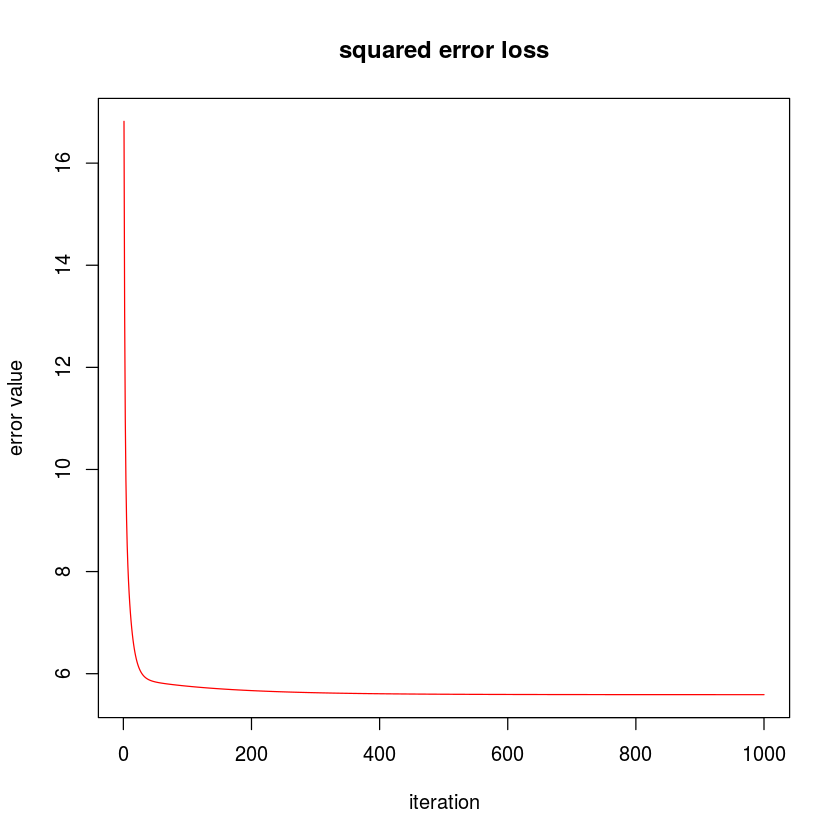

In [22]:
set.seed(1337)
#### simluated data with 3 tricky features
# X = as.matrix(cbind(runif(100, -3, 5), rnorm(100, -2, 10), rnorm(100, 5, 2)))
# Y = as.matrix(0.4 * X[, 1] * 0.3 * X[, 2] + 0.3 * X[, 3]+ rnorm(100) + 2)

#### simluated data with 2 simple features
X = as.matrix(cbind(runif(100, -3, 5), runif(100, -2, 10)))
Y = as.matrix(0.5*X[, 1] + 0.5*X[, 2] + rnorm(100) + 2)
# add intercept
X = cbind(1, X)
n = nrow(X)

# initialize beta with 0
beta = as.matrix(rep(0, ncol(X)))

# set maximum of updates
max.iter = 1000

# function that calculates the squared loss
error = function(Y, X, beta) {
  1 / nrow(X) * t(X %*% beta - Y) %*% (X %*% beta - Y) 
}

# initialize empty data frames for storage
error.storage = data.frame(matrix(0, ncol = 2, nrow = max.iter))
beta.storage = data.frame(matrix(0, ncol = 1 + ncol(X), nrow = max.iter))
error.storage[, 1] = seq(1, max.iter)
beta.storage[, 1] = seq(1, max.iter)

# learning rate
lambda = 0.01

#  loop over gradient updates
for (i in 1:max.iter) {
  beta = beta - lambda * (1/n * (t(X) %*% (X %*% beta - Y)))
  error.storage[i , 2] = error(Y = Y, X = X, beta = beta)
  beta.storage[i , -1] = t(beta)
}

# Plot stuff 
for (i in 1:length(beta)) {
  plot(x = beta.storage[, 1], y = beta.storage[, i + 1], ylab = "coefficient value", 
    xlab = "iteration", type = "l", col = "blue", main = paste0("beta ", i - 1))
}
plot(x = error.storage[, 1], y = error.storage[, 2], ylab = "error value", 
  xlab = "iteration", type = "l", col = "red", main = "squared error loss")

In [23]:
# compare with lm model
df = data.frame(cbind(Y, X[,-1 ]))
colnames(df) = c("Y", seq(1, length(beta) -1 , 1))
mod = lm(Y ~., data = df)
summary(mod)


Call:
lm(formula = Y ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7346 -1.5086  0.0466  1.5296  5.0275 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.09686    0.39182   2.799 0.006178 ** 
`1`          0.97066    0.09938   9.767 4.28e-16 ***
`2`          0.26598    0.07116   3.737 0.000314 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.4 on 97 degrees of freedom
Multiple R-squared:  0.5368,	Adjusted R-squared:  0.5272 
F-statistic:  56.2 on 2 and 97 DF,  p-value: < 2.2e-16


In [24]:
coeffdf = data.frame(cbind(mod$coefficients, beta))
colnames(coeffdf) = c("closed form", "minimization form")
print(coeffdf)

            closed form minimization form
(Intercept)   1.0968634         1.0724863
`1`           0.9706649         0.9726286
`2`           0.2659753         0.2691746
